# Simulation - Tutorial

3D-PLI allows to measure the orientation of nerve fibers in brain section. This document guides you threw the simulated measurementt process and analysis.

After the generation of fiber models (->Sandbox) and making sure no colliding objects are present (->Solver), the models can now be sectioned and visualized inside a virtual 3D-PLI microscope.



## General imports


In [1]:
import fastpli.simulation
import fastpli.analysis
import fastpli.tools
import fastpli.io

import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp

np.random.seed(42)
pool = mp.Pool(2)


The first step is to define the simulation class `Simpli`.

In [2]:
simpli = fastpli.simulation.Simpli()
simpli.omp_num_threads = 2

The next step is to specify all tissue parameters, i.e. the simulation grid `voxel_size` and the section volume of interest `voi`. Since the tissue generation process generates a 3d discrete model, it scales O(nx*ny*nz). Therefore the `Simpli` class provides a `memory_usage()` method to return an estimate for the memory. 

### Note

> A `voxel_size` of 0.5 µm is quite large. It is recommendet to have a `voxel_size` of at least 1/10 smaller then the `pixel_size` and fiber radii.

In [3]:
simpli.voxel_size = 2  # in micro meter
simpli.set_voi([-100,-50,-50], [2300, 500, 50])  # in micro meter
print('Memory:', str(round(simpli.memory_usage('MB'), 2)) + ' MB')

Memory: 314.71 MB


Then the fiber model can be loaded. Here we use a preparied `fastpli.dat` file, which can be read (and saved) with the `fastpli.io` methods. In Addition the layers of each fiber bundle has to be specified.

Each layer (see Wiki) contains out of a radial scaling parameter \[0\], a birefringence strenth \[1\], a absorption coefficient \[2\] and the used optical axis model \[3\].

In [6]:
simpli.fiber_bundles = fastpli.io.fiber_bundles.load('fastpli.dat')
simpli.fiber_bundles.layers = [[(0.666, 0, 5, 'b'),
                                (1.0, 0.004, 1, 'r')]]

Now everything is set to generate all tissue components.
The `tissue` dataset contains a indexed representation of the tissue, with 0 as background and 1 to n for the first fiber bundle and its n layers, n+1 to 2n for the second and so on.
The `optical_axis` contains a (x,y,z) representation of the orientation of the birefringends optical axis, generated with repect to the parallel or radial model provided by the layer component. Last the `tissue_properties` contains a list of the birefringend strength and absorption coefficient in the same order as the indexed `tissue` dataset.

In [7]:
tissue, optical_axis, tissue_properties = simpli.generate_tissue()
print(tissue.shape)
print(optical_axis.shape)
print(tissue_properties)

(1200, 275, 50)
(1200, 275, 50, 3)
[[0.e+00 0.e+00]
 [0.e+00 5.e+00]
 [4.e-03 1.e+00]]


Since we now have our "tissue" we want to measure it in the 3D-PLI microscope.

Again it startes by defining all necesarry parameters for the mesurement. Pleaase read the 3D-PLI setup section in the Wiki to be able to understand all components in more detail.

In [8]:
simpli.filter_rotations = np.deg2rad([0, 30, 60, 90, 120, 150])
simpli.light_intensity = 26000  # a.u.
simpli.wavelength = 525  # in nm
simpli.pixel_size = 10  # in micro meter
simpli.optical_sigma = 0.71  # in pixel size
simpli.noise_model = lambda x: np.random.negative_binomial(
    x / (3 - 1), 1 / 3)
simpli.tilts = np.deg2rad([(0, 0), (5.5, 0), (5.5, 90),
                            (5.5, 180), (5.5, 270)])

In [9]:
tilting_stack = []
for theta, phi in simpli.tilts:
    print(f"Tilt: theta={np.rad2deg(theta):.1f}, phi={np.rad2deg(phi):.1f}")
    images = simpli.run_simulation(tissue, optical_axis, tissue_properties,
                                    theta, phi)

    _, images = simpli.apply_optic(images)
    tilting_stack.append(images)

Tilt: theta=0.0, phi=0.0
Tilt: theta=5.5, phi=0.0
Tilt: theta=5.5, phi=90.0
Tilt: theta=5.5, phi=180.0
Tilt: theta=5.5, phi=270.0


The effitient parallel analysis `epa` calculates the three modalities `transmittance` (2*mean intensity), `direction` (phase) and `retardation` (relative amplitude) of the sinusoidal signal.
The tilting analysis provide by the `ROFL` algorithm a estimation for the `direction`, `inclination` and `t_rel` (relativ birefringend thickness) value of the fibers
With this the fiber orienation map (fom) can be generated.
The rofl analysis can be boosted by the `multiprocessing` module


In [10]:
transmittance, direction, retardation = simpli.apply_epa(tilting_stack[0])
rofl_direction, rofl_incl, rofl_t_rel, _ = simpli.apply_rofl(tilting_stack, mp_pool = pool)
fom = fastpli.analysis.images.fom_hsv_black(rofl_direction, rofl_incl)

## Data visualization

The resulting images can now be visualized

### Note

> All datasets containing spacial information (images, tissue, optical axis) are orded in x-y-z. Since Matplotlib and mostly other visualization libraries or image datasets expect a order of y-x, we have to swap the first two axis first.
> Also it is recommendet to use the interpolation method `nearest`.

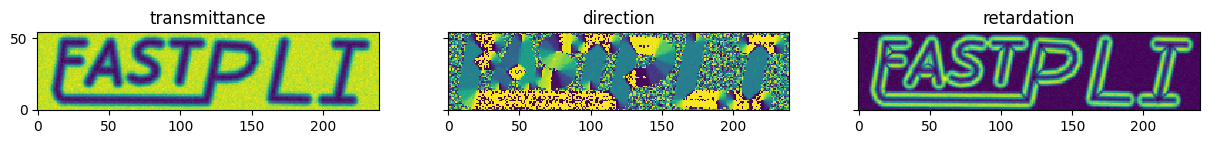

In [11]:
fig, axs = plt.subplots(1,3, sharey=True, figsize=(15,5))
axs[0].imshow(transmittance.T, origin='lower', interpolation='nearest')
axs[0].set_title('transmittance')
axs[1].imshow(direction.T, origin='lower', interpolation='nearest')
axs[1].set_title('direction')
axs[2].imshow(retardation.T, origin='lower', interpolation='nearest')
axs[2].set_title('retardation')
plt.show()

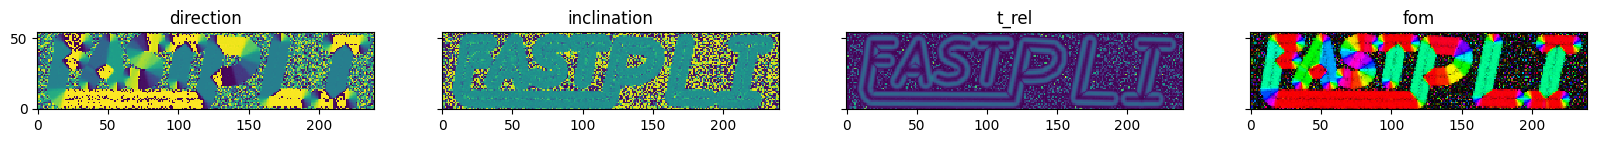

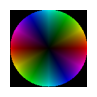

In [12]:
fig, axs = plt.subplots(1,4, sharey=True, figsize=(20,5))
axs[0].imshow(rofl_direction.T, origin='lower', interpolation='nearest')
axs[0].set_title('direction')
axs[1].imshow(rofl_incl.T, origin='lower', interpolation='nearest')
axs[1].set_title('inclination')
axs[2].imshow(rofl_t_rel.T, origin='lower', interpolation='nearest')
axs[2].set_title('t_rel')
axs[3].imshow(np.swapaxes(fom, 0, 1), origin='lower', interpolation='nearest')
axs[3].set_title('fom')
plt.show()

fig, axs = plt.subplots(1,1, figsize=(1,1))
plt.imshow(np.swapaxes(fastpli.analysis.images.hsv_black_sphere(), 0, 1), origin='lower')
plt.axis('off')
plt.show()